# FFNN for Multiclass DICOM CT Scan Classification

Includes:
- DICOM loading from structured folders
- Exclusion of True Benign (TB)
- Image augmentation
- Multiclass FFNN

In [84]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import pydicom
import random
import seaborn as sns

from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import models, layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score
from sklearn.utils.class_weight import compute_class_weight

from albumentations import HorizontalFlip, VerticalFlip, ShiftScaleRotate, RandomBrightnessContrast, GaussianBlur, CoarseDropout
import albumentations as A


In [ ]:
# Parameters
IMG_SIZE = (256, 256)
DATA_PATH = './data/Tampered Scans/Experiment 1 - Blind'
LABELS_CSV = './data/Tampered Scans/labels_exp1.csv'
RANDOM_SEED = 1234

np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

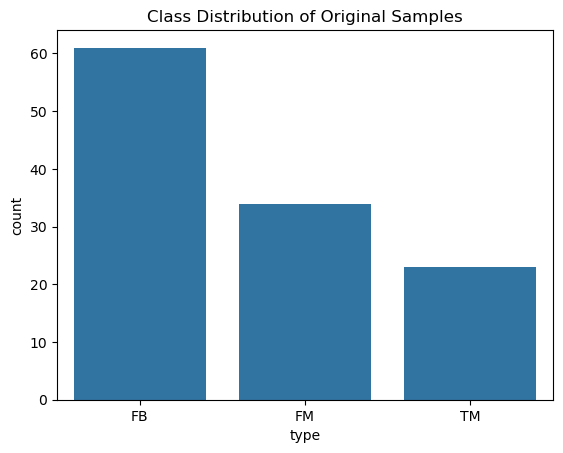

,type,uuid,slice,x,y,dcm_path,filename
0,FB,1280,100,323,381,./data/Tampered Scans/Experiment 1 - Blind/128...,1280_100.png
1,FB,1009,76,354,288,./data/Tampered Scans/Experiment 1 - Blind/100...,1009_76.png
2,FB,7794,79,163,191,./data/Tampered Scans/Experiment 1 - Blind/779...,7794_79.png
3,FB,7794,94,338,243,./data/Tampered Scans/Experiment 1 - Blind/779...,7794_94.png
4,FB,2997,45,156,135,./data/Tampered Scans/Experiment 1 - Blind/299...,2997_45.png


In [104]:
# Load labels and exclude TB
labels_df = pd.read_csv(LABELS_CSV)
labels_df = labels_df[labels_df["type"] != "TB"]
labels_df["dcm_path"] = labels_df.apply(lambda row: os.path.join(DATA_PATH, str(row["uuid"]), f"{row['slice']}.dcm"), axis=1)
labels_df["filename"] = labels_df["uuid"].astype(str) + "_" + labels_df["slice"].astype(str) + ".png"

sns.countplot(data=labels_df, x="type")
plt.title('Class Distribution of Original Samples')
plt.show()

labels_df.head()

In [105]:
# Augmentation setup We will randomly choose these with the p= as the probability of doing that thing
augment = A.Compose([
    HorizontalFlip(p=0.5),
    VerticalFlip(p=0.5),
    ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=15, p=0.5),
    RandomBrightnessContrast(p=0.3),
    GaussianBlur(p=0.2)
])

/home/geon0514/anaconda3/envs/py3jp/lib/python3.12/site-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [106]:
# Read, resize, augment DICOMs
image_data = []
image_labels = []
label_map = {"FB": 0, "FM": 1, "TM": 2}

for _, row in labels_df.iterrows():
    try:
        ds = pydicom.dcmread(row["dcm_path"])
        img = ds.pixel_array.astype(np.float32)
        img = cv2.resize(img, IMG_SIZE)
        img = (img - np.min(img)) / (np.max(img) - np.min(img))  # Normalize

        for _ in range(20): # Edit this number to change how many augmentations image per sample image
            aug = augment(image=img)["image"]
            image_data.append(aug.flatten())
            image_labels.append(label_map[row["type"]])
    except Exception as e:
        print(f"Failed to process {row['dcm_path']}: {e}")
        

In [ ]:
# Prepare arrays
X = np.array(image_data)
Y = to_categorical(image_labels, num_classes=3)

X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, stratify=Y, random_state=RANDOM_SEED)

# Class weights
raw_labels = np.argmax(y_train, axis=1)
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(raw_labels), y=raw_labels)
class_weight_dict = dict(enumerate(class_weights))
print("Class Weights:", class_weight_dict)

Class Weights: {0: 0.644808743169399, 1: 1.1568627450980393, 2: 1.710144927536232}


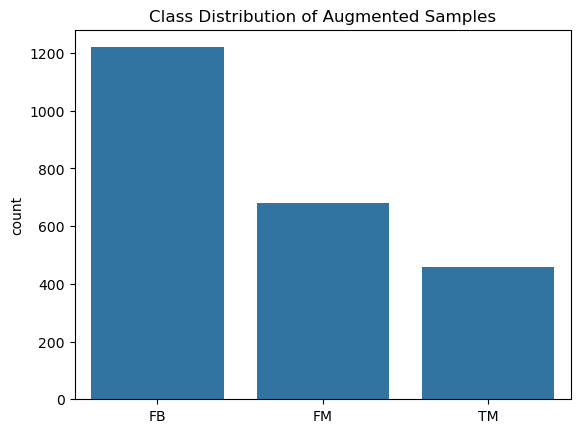

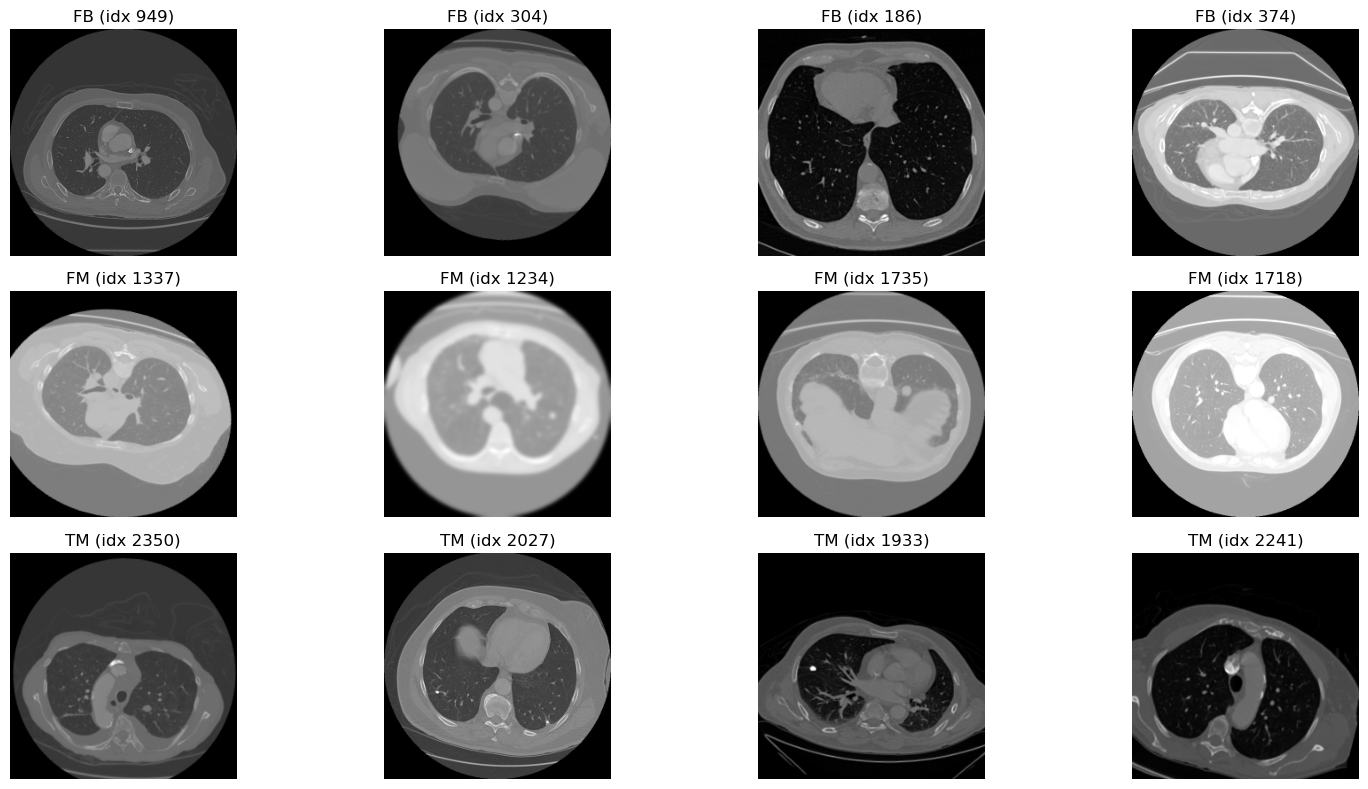

In [ ]:
# Turn Labels into numbers with key values
label_map_inv = {0: 'FB', 1: 'FM', 2: 'TM'}
labels_named = [label_map_inv[i] for i in image_labels]

# Histogram
sns.countplot(x=labels_named)
plt.title('Class Distribution of Augmented Samples')
plt.show()

# Sample 4 images per class
samples_per_class = {}
for class_idx in range(3):
    indices = [i for i, lbl in enumerate(image_labels) if lbl == class_idx]
    selected = random.sample(indices, 4)
    samples_per_class[class_idx] = selected

# Flatten to a single list ordered by class
sample_indices = [idx for class_samples in samples_per_class.values() for idx in class_samples]
sample_images = [image_data[i].reshape(IMG_SIZE) for i in sample_indices]
sample_labels = [label_map_inv[image_labels[i]] for i in sample_indices]

# Plot them (3 rows, 4 per row)
fig, axs = plt.subplots(3, 4, figsize=(16, 8))
for i, (img, label) in enumerate(zip(sample_images, sample_labels)):
    ax = axs[i // 4, i % 4]
    ax.imshow(img, cmap='gray')
    ax.set_title(f"{label} (idx {sample_indices[i]})")
    ax.axis('off')

plt.tight_layout()
plt.show()

In [112]:
# Build FFNN
model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_shape=(X.shape[1],)))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(3, activation='softmax'))

model.compile(
    optimizer=Adam(1e-4),
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        Precision(name='precision'),
        Recall(name='recall')
    ]
)


In [113]:
# Train
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    class_weight=class_weight_dict
)

Epoch 1/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - accuracy: 0.4093 - loss: 1.8865 - precision: 0.4161 - recall: 0.3496 - val_accuracy: 0.4195 - val_loss: 1.0046 - val_precision: 0.6068 - val_recall: 0.2648
Epoch 2/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.4322 - loss: 0.9798 - precision: 0.5010 - recall: 0.2070 - val_accuracy: 0.6081 - val_loss: 0.9320 - val_precision: 0.6870 - val_recall: 0.1674
Epoch 3/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - accuracy: 0.4542 - loss: 0.9602 - precision: 0.5478 - recall: 0.1958 - val_accuracy: 0.4597 - val_loss: 0.9352 - val_precision: 0.7651 - val_recall: 0.2415
Epoch 4/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.4903 - loss: 0.9263 - precision: 0.6285 - recall: 0.2399 - val_accuracy: 0.4068 - val_loss: 0.9459 - val_precision: 0.6864 - val_recall: 0.3199
Epoch 5/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.4654 - loss: 0.8941 - precision: 0.6007 - recall: 0.2409 - val_accuracy: 0.5127 - val_loss: 0.9190 

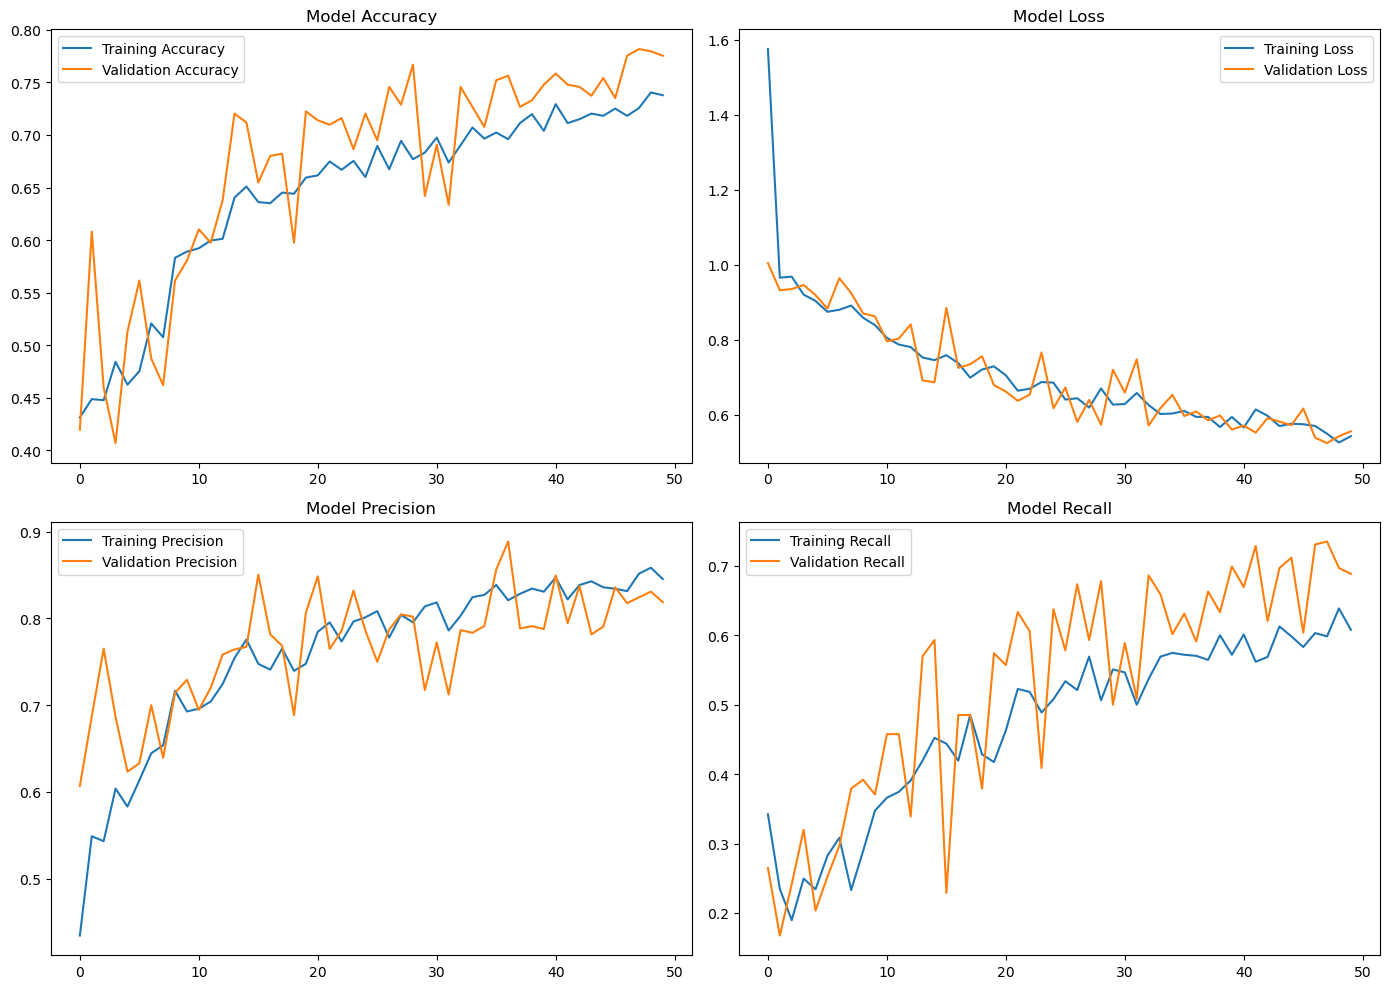

In [114]:
# Plot training history
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# Accuracy
axs[0, 0].plot(history.history['accuracy'], label='Training Accuracy')
axs[0, 0].plot(history.history['val_accuracy'], label='Validation Accuracy')
axs[0, 0].set_title('Model Accuracy')
axs[0, 0].legend()

# Loss
axs[0, 1].plot(history.history['loss'], label='Training Loss')
axs[0, 1].plot(history.history['val_loss'], label='Validation Loss')
axs[0, 1].set_title('Model Loss')
axs[0, 1].legend()

# Precision
axs[1, 0].plot(history.history['precision'], label='Training Precision')
axs[1, 0].plot(history.history['val_precision'], label='Validation Precision')
axs[1, 0].set_title('Model Precision')
axs[1, 0].legend()

# Recall
axs[1, 1].plot(history.history['recall'], label='Training Recall')
axs[1, 1].plot(history.history['val_recall'], label='Validation Recall')
axs[1, 1].set_title('Model Recall')
axs[1, 1].legend()

plt.tight_layout()
plt.show()


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


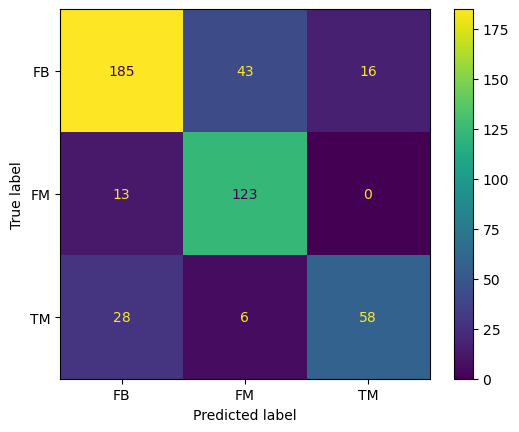

In [115]:
# Confusion matrix
preds = model.predict(X_val)
y_pred = np.argmax(preds, axis=1)
y_true = np.argmax(y_val, axis=1)

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["FB", "FM", "TM"])
disp.plot()
plt.show()